# Title: Predict_orthologs
### Author: Mathieu Giguere

Brief: Uses machine learning to predict the resistance of FKS1-HS1 Orthologs amino acid sequences to an antifungal drug by training a model on single mutants amino acid sequences. The model uses Expasy Protscale's amino acid properties as features.

Preconditions: Needs Romain Durand's 'nt_refined_classification.csv' from his 'DMS-main' repository and 'aminoAcidProperties.txt'.



In [1]:
# importing modules and packages
import pandas as pd
import numpy as np
np.bool = np.bool_
np.int = np.int_
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import balanced_accuracy_score, confusion_matrix, roc_auc_score, matthews_corrcoef, roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import glob
import os

## Define the antifungal drug used.

In [2]:
# VIP. Very important parameter. The Antifungal drug.
# Choices are : 'caspofungin', 'anidulafungin', 'micafungin'
drug = 'micafungin'

# Dictionary to convert 3-level resistance classification to 2-level
parse_res_class = {'deleterious':'sensitive',
                   'slightly deleterious':'sensitive',
                   'WT-like':'sensitive',
                   'intermediary':'resistant',
                   'resistant':'resistant'
                  }

## Make a usable dataframe from the data.

In [3]:
df = pd.read_csv('nt_refined_classification.csv', index_col=0)


drug_master = df[df.compound == drug][['compound', 'seq_type', 'Nham_aa', 'aa_seq', 's', 'refined_class']]
drug_master['resistance'] = drug_master.refined_class.replace(parse_res_class)
drug_master = drug_master.drop(columns='refined_class').reset_index(drop=True)
drug_master

,compound,seq_type,Nham_aa,aa_seq,s,resistance
0,micafungin,ortho,1.0,FLILSLRDP,0.070680,sensitive
1,micafungin,ortho,1.0,FLTLSLRDP,-0.159237,sensitive
2,micafungin,ortho,2.0,FLALSFRDP,-0.005718,sensitive
3,micafungin,ortho,2.0,FLALSIRDP,0.106098,sensitive
4,micafungin,ortho,2.0,FLSLSFRDP,1.747797,resistant
...,...,...,...,...,...,...
309,micafungin,single,1.0,TLVLSLRDP,1.566037,resistant
310,micafungin,single,1.0,TLVLSLRDP,2.121378,resistant
311,micafungin,single,1.0,VLVLSLRDP,2.017570,resistant
312,micafungin,single,1.0,WLVLSLRDP,2.013342,resistant


## Import amino acid properties

In [4]:
# Amino acid properties
AAproperties = pd.read_table('aminoAcidProperties.txt')
AAproperties.rename(columns={'Aminoacid.1.letter': 'aa1'}, inplace=True)
AAproperties

,aa1,alpha_helix_chou,alpha_helix_deleage,alpha_helix_levitt,aminoacid_composition_swissprot_bairoch,antiparallel_beta_strand_lifson,average_area_buried_folding_rose,average_flexibility_bhaskaran,average_surrounding_hydrophobicity_manavalan,beta_sheet_chou,...,recognition_factors,refractivity,relative_mutability_ala100_dayhoff,retention_coefficient_hfba_browne,retention_coefficient_ph2.1_meek,retention_coefficient_ph7.4_meek,retention_coefficient_tfa_browne,total_beta_strand_lifson,transmembrane_tendency_zhao,levy_propensity
0,A,1.42,1.489,1.29,8.25,0.90,86.6,0.36,12.97,0.83,...,78,4.34,100,3.9,-0.1,0.5,7.3,0.92,0.38,0.0062
1,C,0.70,0.966,1.11,1.37,1.24,132.3,0.35,14.63,1.19,...,89,35.77,20,-14.3,-2.2,-6.8,-9.2,1.16,-0.30,1.0372
2,D,1.01,0.924,1.04,5.45,0.47,97.8,0.51,10.85,0.54,...,81,12.00,106,-2.8,-2.8,-8.2,-2.9,0.48,-3.27,-0.7485
3,E,1.51,1.504,1.44,6.75,0.62,113.9,0.50,11.89,0.37,...,78,17.26,102,-7.5,-7.5,-16.9,-7.1,0.61,-2.90,-0.7893
4,F,1.13,1.195,1.07,3.86,1.23,194.1,0.31,14.00,1.38,...,81,29.40,41,14.7,13.9,13.2,19.2,1.25,1.98,1.2727
5,G,0.57,0.510,0.56,7.07,0.56,62.9,0.54,12.43,0.75,...,84,0.00,49,-2.3,-0.5,0.0,-1.2,0.61,-0.19,-0.1771
6,H,1.00,1.003,1.22,2.27,1.12,155.8,0.32,12.16,0.87,...,84,21.81,66,2.0,0.8,-3.5,-2.1,0.93,-1.44,0.1204
7,I,1.08,1.003,0.97,5.96,1.54,158.0,0.46,15.67,1.60,...,88,19.06,96,11.0,11.8,13.9,6.6,1.81,1.97,1.1109
8,K,1.16,1.172,1.23,5.84,0.74,115.5,0.47,11.36,0.74,...,87,21.29,56,-2.5,-3.2,0.1,-3.7,0.70,-3.46,-1.1806
9,L,1.21,1.236,1.30,9.66,1.26,164.1,0.37,14.90,1.30,...,85,18.78,40,15.0,10.0,8.8,20.0,1.30,1.82,0.9138


## Create training dataframe on single mutants

In [5]:
#Single_master = drug_master.loc[(drug_master['seq_type'] == 'single')]

Single_master = drug_master.loc[drug_master.Nham_aa <=1]

# Explode aa_seq into many columns
Single_master[['aa1', 'aa2', 'aa3', 'aa4', 'aa5', 'aa6', 'aa7', 'aa8', 'aa9']] = Single_master['aa_seq'].apply(lambda x: pd.Series(list(x)))

Single_master

/tmp/ipykernel_5602/1096710807.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Single_master[['aa1', 'aa2', 'aa3', 'aa4', 'aa5', 'aa6', 'aa7', 'aa8', 'aa9']] = Single_master['aa_seq'].apply(lambda x: pd.Series(list(x)))
/tmp/ipykernel_5602/1096710807.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Single_master[['aa1', 'aa2', 'aa3', 'aa4', 'aa5', 'aa6', 'aa7', 'aa8', 'aa9']] = Single_master['aa_seq'].apply(lambda x: pd.Series(list(x)))
/tmp/ipykernel_5602/1096710807.py:6: SettingWithCopyWarning: 
A 

,compound,seq_type,Nham_aa,aa_seq,s,resistance,aa1,aa2,aa3,aa4,aa5,aa6,aa7,aa8,aa9
0,micafungin,ortho,1.0,FLILSLRDP,0.070680,sensitive,F,L,I,L,S,L,R,D,P
1,micafungin,ortho,1.0,FLTLSLRDP,-0.159237,sensitive,F,L,T,L,S,L,R,D,P
48,micafungin,single,0.0,FLVLSLRDP,-0.375188,sensitive,F,L,V,L,S,L,R,D,P
49,micafungin,single,0.0,FLVLSLRDP,0.023683,sensitive,F,L,V,L,S,L,R,D,P
50,micafungin,single,0.0,FLVLSLRDP,0.971301,resistant,F,L,V,L,S,L,R,D,P
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
309,micafungin,single,1.0,TLVLSLRDP,1.566037,resistant,T,L,V,L,S,L,R,D,P
310,micafungin,single,1.0,TLVLSLRDP,2.121378,resistant,T,L,V,L,S,L,R,D,P
311,micafungin,single,1.0,VLVLSLRDP,2.017570,resistant,V,L,V,L,S,L,R,D,P
312,micafungin,single,1.0,WLVLSLRDP,2.013342,resistant,W,L,V,L,S,L,R,D,P


In [6]:
# Merge dataframe with AAproperties
Single_merged = pd.merge(left=Single_master, right=AAproperties, how='inner', indicator='location1', suffixes=(None, '_aa1'), on='aa1')

AAproperties.rename(columns={'aa1': 'aa2'}, inplace=True)
Single_merged = pd.merge(left=Single_merged, right=AAproperties, how='inner', indicator='location2', suffixes=(None, '_aa2'),
                  on='aa2')

AAproperties.rename(columns={'aa2': 'aa3'}, inplace=True)
Single_merged = pd.merge(left=Single_merged, right=AAproperties, how='inner', indicator='location3', suffixes=(None, '_aa3'),
                  on='aa3')

AAproperties.rename(columns={'aa3': 'aa4'}, inplace=True)
Single_merged = pd.merge(left=Single_merged, right=AAproperties, how='inner', indicator='location4', suffixes=(None, '_aa4'),
                  on='aa4')

AAproperties.rename(columns={'aa4': 'aa5'}, inplace=True)
Single_merged = pd.merge(left=Single_merged, right=AAproperties, how='inner', indicator='location5', suffixes=(None, '_aa5'),
                  on='aa5')

AAproperties.rename(columns={'aa5': 'aa6'}, inplace=True)
Single_merged = pd.merge(left=Single_merged, right=AAproperties, how='inner', indicator='location6', suffixes=(None, '_aa6'),
                  on='aa6')

AAproperties.rename(columns={'aa6': 'aa7'}, inplace=True)
Single_merged = pd.merge(left=Single_merged, right=AAproperties, how='inner', indicator='location7', suffixes=(None, '_aa7'),
                  on='aa7')

AAproperties.rename(columns={'aa7': 'aa8'}, inplace=True)
Single_merged = pd.merge(left=Single_merged, right=AAproperties, how='inner', indicator='location8', suffixes=(None, '_aa8'),
                  on='aa8')

AAproperties.rename(columns={'aa8': 'aa9'}, inplace=True)
Single_merged = pd.merge(left=Single_merged, right=AAproperties, how='inner', indicator='location9', suffixes=(None, '_aa9'),
                  on='aa9')

Single_merged

,compound,seq_type,Nham_aa,aa_seq,s,resistance,aa1,aa2,aa3,aa4,...,refractivity_aa9,relative_mutability_ala100_dayhoff_aa9,retention_coefficient_hfba_browne_aa9,retention_coefficient_ph2.1_meek_aa9,retention_coefficient_ph7.4_meek_aa9,retention_coefficient_tfa_browne_aa9,total_beta_strand_lifson_aa9,transmembrane_tendency_zhao_aa9,levy_propensity_aa9,location9
0,micafungin,ortho,1.0,FLILSLRDP,0.070680,sensitive,F,L,I,L,...,10.93,56,5.6,8.0,6.1,5.1,0.40,-1.44,-0.1799,both
1,micafungin,single,1.0,FLILSLRDP,-0.082347,sensitive,F,L,I,L,...,10.93,56,5.6,8.0,6.1,5.1,0.40,-1.44,-0.1799,both
2,micafungin,ortho,1.0,FLTLSLRDP,-0.159237,sensitive,F,L,T,L,...,10.93,56,5.6,8.0,6.1,5.1,0.40,-1.44,-0.1799,both
3,micafungin,single,1.0,FLTLSLRDP,0.112423,sensitive,F,L,T,L,...,10.93,56,5.6,8.0,6.1,5.1,0.40,-1.44,-0.1799,both
4,micafungin,single,1.0,FLTLSLRDP,0.030144,sensitive,F,L,T,L,...,10.93,56,5.6,8.0,6.1,5.1,0.40,-1.44,-0.1799,both
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
254,micafungin,single,1.0,FLVLSLRDT,2.083849,resistant,F,L,V,L,...,11.01,97,1.1,1.5,2.7,0.8,1.12,-0.32,0.1031,both
255,micafungin,single,1.0,FLVLSLRDV,1.892884,resistant,F,L,V,L,...,13.92,74,2.1,3.3,2.7,3.5,1.81,1.46,0.7599,both
256,micafungin,single,1.0,FLVLSLRDV,1.847534,resistant,F,L,V,L,...,13.92,74,2.1,3.3,2.7,3.5,1.81,1.46,0.7599,both
257,micafungin,single,1.0,FLVLSLRDW,-0.019411,sensitive,F,L,V,L,...,42.53,18,17.8,18.1,14.9,16.3,1.54,1.53,0.7925,both


In [7]:
# Get training data for machine learning.
X_train = Single_merged.drop(columns=['seq_type', 'aa_seq', 'compound', 's', 'Nham_aa', 'resistance',
                                      'location1', 'location2', 'location3', 'location4', 'location5', 'location6', 'location7', 'location8', 'location9',
                                      'aa1', 'aa2', 'aa3', 'aa4', 'aa5', 'aa6', 'aa7', 'aa8', 'aa9'])

X_train

,alpha_helix_chou,alpha_helix_deleage,alpha_helix_levitt,aminoacid_composition_swissprot_bairoch,antiparallel_beta_strand_lifson,average_area_buried_folding_rose,average_flexibility_bhaskaran,average_surrounding_hydrophobicity_manavalan,beta_sheet_chou,beta_sheet_deleage,...,recognition_factors_aa9,refractivity_aa9,relative_mutability_ala100_dayhoff_aa9,retention_coefficient_hfba_browne_aa9,retention_coefficient_ph2.1_meek_aa9,retention_coefficient_ph7.4_meek_aa9,retention_coefficient_tfa_browne_aa9,total_beta_strand_lifson_aa9,transmembrane_tendency_zhao_aa9,levy_propensity_aa9
0,1.13,1.195,1.07,3.86,1.23,194.1,0.31,14.0,1.38,1.393,...,91,10.93,56,5.6,8.0,6.1,5.1,0.40,-1.44,-0.1799
1,1.13,1.195,1.07,3.86,1.23,194.1,0.31,14.0,1.38,1.393,...,91,10.93,56,5.6,8.0,6.1,5.1,0.40,-1.44,-0.1799
2,1.13,1.195,1.07,3.86,1.23,194.1,0.31,14.0,1.38,1.393,...,91,10.93,56,5.6,8.0,6.1,5.1,0.40,-1.44,-0.1799
3,1.13,1.195,1.07,3.86,1.23,194.1,0.31,14.0,1.38,1.393,...,91,10.93,56,5.6,8.0,6.1,5.1,0.40,-1.44,-0.1799
4,1.13,1.195,1.07,3.86,1.23,194.1,0.31,14.0,1.38,1.393,...,91,10.93,56,5.6,8.0,6.1,5.1,0.40,-1.44,-0.1799
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
254,1.13,1.195,1.07,3.86,1.23,194.1,0.31,14.0,1.38,1.393,...,93,11.01,97,1.1,1.5,2.7,0.8,1.12,-0.32,0.1031
255,1.13,1.195,1.07,3.86,1.23,194.1,0.31,14.0,1.38,1.393,...,89,13.92,74,2.1,3.3,2.7,3.5,1.81,1.46,0.7599
256,1.13,1.195,1.07,3.86,1.23,194.1,0.31,14.0,1.38,1.393,...,89,13.92,74,2.1,3.3,2.7,3.5,1.81,1.46,0.7599
257,1.13,1.195,1.07,3.86,1.23,194.1,0.31,14.0,1.38,1.393,...,104,42.53,18,17.8,18.1,14.9,16.3,1.54,1.53,0.7925


In [8]:
y_train = Single_merged['resistance']

y_train

0      sensitive
1      sensitive
2      sensitive
3      sensitive
4      sensitive
         ...    
254    resistant
255    resistant
256    resistant
257    sensitive
258    resistant
Name: resistance, Length: 259, dtype: object

## Create Orthologs Prediction (test) dataframe

In [9]:
#Ortho_master = drug_master.loc[(drug_master['seq_type'] == 'ortho')]

Ortho_master = drug_master.loc[drug_master.Nham_aa > 1]

# Explode aa_seq into many columns
Ortho_master[['aa1', 'aa2', 'aa3', 'aa4', 'aa5', 'aa6', 'aa7', 'aa8', 'aa9']] = Ortho_master['aa_seq'].apply(lambda x: pd.Series(list(x)))

Ortho_master

/tmp/ipykernel_5602/1296760393.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Ortho_master[['aa1', 'aa2', 'aa3', 'aa4', 'aa5', 'aa6', 'aa7', 'aa8', 'aa9']] = Ortho_master['aa_seq'].apply(lambda x: pd.Series(list(x)))
/tmp/ipykernel_5602/1296760393.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Ortho_master[['aa1', 'aa2', 'aa3', 'aa4', 'aa5', 'aa6', 'aa7', 'aa8', 'aa9']] = Ortho_master['aa_seq'].apply(lambda x: pd.Series(list(x)))
/tmp/ipykernel_5602/1296760393.py:6: SettingWithCopyWarning: 
A valu

,compound,seq_type,Nham_aa,aa_seq,s,resistance,aa1,aa2,aa3,aa4,aa5,aa6,aa7,aa8,aa9
2,micafungin,ortho,2.0,FLALSFRDP,-0.005718,sensitive,F,L,A,L,S,F,R,D,P
3,micafungin,ortho,2.0,FLALSIRDP,0.106098,sensitive,F,L,A,L,S,I,R,D,P
4,micafungin,ortho,2.0,FLSLSFRDP,1.747797,resistant,F,L,S,L,S,F,R,D,P
5,micafungin,ortho,2.0,FLTLSFRDP,-0.057487,sensitive,F,L,T,L,S,F,R,D,P
6,micafungin,ortho,2.0,FLTLSIRDP,-0.000784,sensitive,F,L,T,L,S,I,R,D,P
7,micafungin,ortho,2.0,FLTLSLKDP,0.263013,sensitive,F,L,T,L,S,L,K,D,P
8,micafungin,ortho,2.0,FLTLSLRDA,1.642593,resistant,F,L,T,L,S,L,R,D,A
9,micafungin,ortho,2.0,FLTLSLVDP,0.249038,sensitive,F,L,T,L,S,L,V,D,P
10,micafungin,ortho,2.0,FLTLSVRDP,-0.167529,sensitive,F,L,T,L,S,V,R,D,P
11,micafungin,ortho,2.0,FMALSLRDP,-0.223274,sensitive,F,M,A,L,S,L,R,D,P


In [10]:
# Merge dataframe with AAproperties
AAproperties.rename(columns={'aa9': 'aa1'}, inplace=True)
Ortho_merged = pd.merge(left=Ortho_master, right=AAproperties, how='inner', indicator='location1', suffixes=(None, '_aa1'),
                  on='aa1')

AAproperties.rename(columns={'aa1': 'aa2'}, inplace=True)
Ortho_merged = pd.merge(left=Ortho_merged, right=AAproperties, how='inner', indicator='location2', suffixes=(None, '_aa2'),
                  on='aa2')

AAproperties.rename(columns={'aa2': 'aa3'}, inplace=True)
Ortho_merged = pd.merge(left=Ortho_merged, right=AAproperties, how='inner', indicator='location3', suffixes=(None, '_aa3'),
                  on='aa3')

AAproperties.rename(columns={'aa3': 'aa4'}, inplace=True)
Ortho_merged = pd.merge(left=Ortho_merged, right=AAproperties, how='inner', indicator='location4', suffixes=(None, '_aa4'),
                  on='aa4')

AAproperties.rename(columns={'aa4': 'aa5'}, inplace=True)
Ortho_merged = pd.merge(left=Ortho_merged, right=AAproperties, how='inner', indicator='location5', suffixes=(None, '_aa5'),
                  on='aa5')

AAproperties.rename(columns={'aa5': 'aa6'}, inplace=True)
Ortho_merged = pd.merge(left=Ortho_merged, right=AAproperties, how='inner', indicator='location6', suffixes=(None, '_aa6'),
                  on='aa6')

AAproperties.rename(columns={'aa6': 'aa7'}, inplace=True)
Ortho_merged = pd.merge(left=Ortho_merged, right=AAproperties, how='inner', indicator='location7', suffixes=(None, '_aa7'),
                  on='aa7')

AAproperties.rename(columns={'aa7': 'aa8'}, inplace=True)
Ortho_merged = pd.merge(left=Ortho_merged, right=AAproperties, how='inner', indicator='location8', suffixes=(None, '_aa8'),
                  on='aa8')

AAproperties.rename(columns={'aa8': 'aa9'}, inplace=True)
Ortho_merged = pd.merge(left=Ortho_merged, right=AAproperties, how='inner', indicator='location9', suffixes=(None, '_aa9'),
                  on='aa9')

Ortho_merged

,compound,seq_type,Nham_aa,aa_seq,s,resistance,aa1,aa2,aa3,aa4,...,refractivity_aa9,relative_mutability_ala100_dayhoff_aa9,retention_coefficient_hfba_browne_aa9,retention_coefficient_ph2.1_meek_aa9,retention_coefficient_ph7.4_meek_aa9,retention_coefficient_tfa_browne_aa9,total_beta_strand_lifson_aa9,transmembrane_tendency_zhao_aa9,levy_propensity_aa9,location9
0,micafungin,ortho,2.0,FLALSFRDP,-0.005718,sensitive,F,L,A,L,...,10.93,56,5.6,8.0,6.1,5.1,0.40,-1.44,-0.1799,both
1,micafungin,ortho,3.0,YLALSFRDP,2.096703,resistant,Y,L,A,L,...,10.93,56,5.6,8.0,6.1,5.1,0.40,-1.44,-0.1799,both
2,micafungin,ortho,2.0,FLSLSFRDP,1.747797,resistant,F,L,S,L,...,10.93,56,5.6,8.0,6.1,5.1,0.40,-1.44,-0.1799,both
3,micafungin,ortho,2.0,FLTLSFRDP,-0.057487,sensitive,F,L,T,L,...,10.93,56,5.6,8.0,6.1,5.1,0.40,-1.44,-0.1799,both
4,micafungin,ortho,3.0,YLTLSFRDP,2.067241,resistant,Y,L,T,L,...,10.93,56,5.6,8.0,6.1,5.1,0.40,-1.44,-0.1799,both
5,micafungin,ortho,3.0,ALTLSFRDP,2.189590,resistant,A,L,T,L,...,10.93,56,5.6,8.0,6.1,5.1,0.40,-1.44,-0.1799,both
6,micafungin,ortho,3.0,YLILSFRDP,2.145771,resistant,Y,L,I,L,...,10.93,56,5.6,8.0,6.1,5.1,0.40,-1.44,-0.1799,both
7,micafungin,ortho,3.0,FLTHSFRDP,2.162517,resistant,F,L,T,H,...,10.93,56,5.6,8.0,6.1,5.1,0.40,-1.44,-0.1799,both
8,micafungin,ortho,4.0,YLTRSFRDP,2.170691,resistant,Y,L,T,R,...,10.93,56,5.6,8.0,6.1,5.1,0.40,-1.44,-0.1799,both
9,micafungin,ortho,2.0,FLALSIRDP,0.106098,sensitive,F,L,A,L,...,10.93,56,5.6,8.0,6.1,5.1,0.40,-1.44,-0.1799,both


In [11]:
# Get testing data for machine learning.
X_test = Ortho_merged.drop(columns=['seq_type', 'aa_seq', 'compound', 's', 'Nham_aa', 'resistance',
                                    'location1', 'location2', 'location3', 'location4', 'location5', 'location6', 'location7', 'location8', 'location9',
                                    'aa1', 'aa2', 'aa3', 'aa4', 'aa5', 'aa6', 'aa7', 'aa8', 'aa9'])

X_test

,alpha_helix_chou,alpha_helix_deleage,alpha_helix_levitt,aminoacid_composition_swissprot_bairoch,antiparallel_beta_strand_lifson,average_area_buried_folding_rose,average_flexibility_bhaskaran,average_surrounding_hydrophobicity_manavalan,beta_sheet_chou,beta_sheet_deleage,...,recognition_factors_aa9,refractivity_aa9,relative_mutability_ala100_dayhoff_aa9,retention_coefficient_hfba_browne_aa9,retention_coefficient_ph2.1_meek_aa9,retention_coefficient_ph7.4_meek_aa9,retention_coefficient_tfa_browne_aa9,total_beta_strand_lifson_aa9,transmembrane_tendency_zhao_aa9,levy_propensity_aa9
0,1.13,1.195,1.07,3.86,1.23,194.1,0.31,14.00,1.38,1.393,...,91,10.93,56,5.6,8.0,6.1,5.1,0.40,-1.44,-0.1799
1,0.69,0.787,0.72,2.92,1.68,177.7,0.42,13.42,1.47,1.266,...,91,10.93,56,5.6,8.0,6.1,5.1,0.40,-1.44,-0.1799
2,1.13,1.195,1.07,3.86,1.23,194.1,0.31,14.00,1.38,1.393,...,91,10.93,56,5.6,8.0,6.1,5.1,0.40,-1.44,-0.1799
3,1.13,1.195,1.07,3.86,1.23,194.1,0.31,14.00,1.38,1.393,...,91,10.93,56,5.6,8.0,6.1,5.1,0.40,-1.44,-0.1799
4,0.69,0.787,0.72,2.92,1.68,177.7,0.42,13.42,1.47,1.266,...,91,10.93,56,5.6,8.0,6.1,5.1,0.40,-1.44,-0.1799
5,1.42,1.489,1.29,8.25,0.90,86.6,0.36,12.97,0.83,0.709,...,91,10.93,56,5.6,8.0,6.1,5.1,0.40,-1.44,-0.1799
6,0.69,0.787,0.72,2.92,1.68,177.7,0.42,13.42,1.47,1.266,...,91,10.93,56,5.6,8.0,6.1,5.1,0.40,-1.44,-0.1799
7,1.13,1.195,1.07,3.86,1.23,194.1,0.31,14.00,1.38,1.393,...,91,10.93,56,5.6,8.0,6.1,5.1,0.40,-1.44,-0.1799
8,0.69,0.787,0.72,2.92,1.68,177.7,0.42,13.42,1.47,1.266,...,91,10.93,56,5.6,8.0,6.1,5.1,0.40,-1.44,-0.1799
9,1.13,1.195,1.07,3.86,1.23,194.1,0.31,14.00,1.38,1.393,...,91,10.93,56,5.6,8.0,6.1,5.1,0.40,-1.44,-0.1799


In [12]:
y_test = Ortho_merged['resistance']

y_test

0     sensitive
1     resistant
2     resistant
3     sensitive
4     resistant
5     resistant
6     resistant
7     resistant
8     resistant
9     sensitive
10    sensitive
11    resistant
12    resistant
13    sensitive
14    resistant
15    resistant
16    sensitive
17    sensitive
18    resistant
19    sensitive
20    resistant
21    sensitive
22    resistant
23    resistant
24    sensitive
25    sensitive
26    resistant
27    sensitive
28    sensitive
29    resistant
30    resistant
31    resistant
32    resistant
33    resistant
34    resistant
35    resistant
36    sensitive
37    resistant
38    resistant
39    resistant
40    resistant
41    resistant
42    resistant
43    resistant
44    resistant
45    resistant
Name: resistance, dtype: object

## Machine Learning

### Hyperparameters tunning

In [13]:
def learn (clf, X_train, X_test, y_train, y_test):
    
    clf.fit(X_train, y_train)
    
    y_pred_train = clf.predict(X_train)
    y_pred_test = clf.predict (X_test)
    
    bal_acc_train = balanced_accuracy_score(y_train, y_pred_train)
    bal_acc_test = balanced_accuracy_score(y_test, y_pred_test)
    
    return y_test, y_pred_test, bal_acc_train, bal_acc_test

In [26]:
test_bal_acc = []
hyper_feat = []
hyper_depth = []

for f in [19,20,21,23,25,27]:
    for d in [12,13,14,15,16,17,20]:
        
        clf = RandomForestClassifier(random_state=18, n_estimators=100, max_features=f, max_depth=d)
        
        truth, predictions, bal_acc_train, bal_acc_test = learn(clf, X_train, X_test, y_train, y_test)
        
        test_bal_acc.append(bal_acc_test)
        hyper_feat.append(f)
        hyper_depth.append(d)

In [27]:
df = pd.DataFrame({'max_depth' : hyper_depth, 'max_features' : hyper_feat, 'balanced_accuracy' : test_bal_acc})
df_pivot = pd.pivot_table(df, index='max_depth', columns='max_features', values='balanced_accuracy')

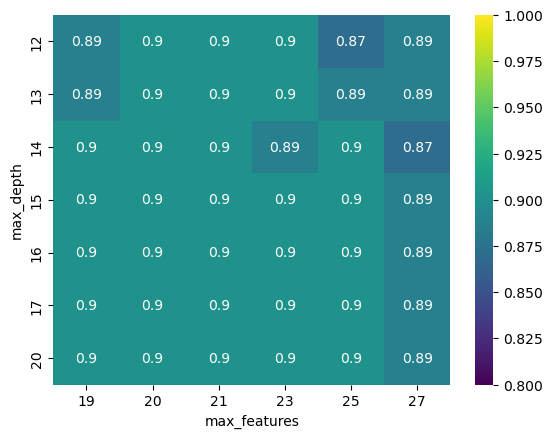

In [28]:
sns.heatmap(df_pivot, annot=True, cmap='viridis', vmin=0.8, vmax=1.0)
plt.savefig('hypers.svg')